# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

## The binomial distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.  All four outcomes have the same probability, 25%.  

If we add up the total number of heads, there are three possible outcomes: 0, 1, or 2.  The probability of 0 and 2 is 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is `p` and we spin the coin `n` times.  What is the probability that we get a total of `k` heads?

The answer is given by the binomial distribution:

$P(k; n, p) = \binom{n}{k} p^k (1-p)^{n-k}$

where $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We can compute this expression ourselves, but we can also use the SciPy function `binom.pmf`:

In [49]:
from scipy.stats import binom

n = 2
p = 0.5
ks = np.arange(n+1)

a = binom.pmf(ks, n, p)
a

array([0.25, 0.5 , 0.25])

If we put this result in a `Pmf`, the result is the distribution of `k` for the given values of `n` and `p`.

In [50]:
pmf_k = Pmf(a, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [51]:
from utils import write_pmf
write_pmf(pmf_k, 'table03-01')

The following function computes the binomial distribution for given values of `n` and `p`:

In [52]:
def make_binomial(n, p):
    """Make a binomial PMF.
    
    n: number of spins
    p: probability of heads
    
    returns: Pmf representing the distribution
    """
    ks = np.arange(n+1)
    a = binom.pmf(ks, n, p)
    return Pmf(a, ks)

And here's what it looks like with `n=250` and `p=0.5`:

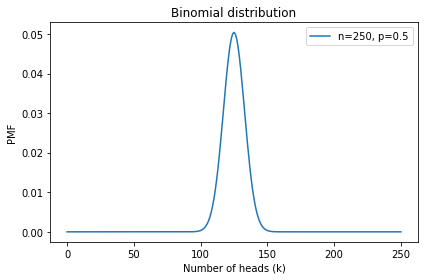

In [53]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

savefig('fig03-01')

The most likely value in this distribution is 125:

In [7]:
pmf_k.max_prob()

125

But even though it is the most likely value, the probability that we get exactly 125 heads is only about 5%.

In [8]:
pmf_k[125]

0.05041221314731537

In MacKay's example, we got 140 heads, which is less likely than 125:

In [9]:
pmf_k[140]

0.008357181724917673

In the article MacKay quotes, the statistician says, ‘If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%’.

We can use the binomial distribution to check his math.  The following function takes a PMF and computes the total probability of values greater than or equal to `threshold`. 

In [10]:
def ge_dist(pmf, threshold):
    """Probability of values greater than a threshold.
    
    pmf: Series representing a PMF
    threshold: value to compare to
    
    returns: probability
    """
    ge = (pmf.index >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [11]:
ge_dist(pmf_k, 140)

0.033210575620022706

`Pmf` provides a method that does the same computation.

In [12]:
pmf_k.ge_dist(140)

0.033210575620022706

The result is about 3.3%, which is less than 7%.  The reason is that the statistician includes all values "as extreme as" 140, which includes values less than or equal to 110, because 140 exceeds the expected value by 15 and 110 falls short by 15.

In [13]:
pmf_k.le_dist(110)

0.033210575620022706

The probability of values less than or equal to 110 is also 3.3%,
so the total probability of values "as extreme" as 140 is 6.6%.

The point of this calculation is that these extreme values are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question.  Let's see if we can.

## The Euro problem


We can make a uniform prior and update it with 140 heads and 110 tails:

In [73]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

I'll use a dictionary to store the likelihoods for `H` and `T`:

In [74]:
likelihood = {
    'H': hypos,
    'T': 1 - hypos
}

I'll use a list of strings to represent the dataset:


In [75]:
dataset = 'H' * 140 + 'T' * 110

The following function does the update.

In [76]:
def update_euro(pmf, dataset):
    """Updates the Suite with the given number of heads and tails.

    pmf: Pmf representing the prior
    data: tuple of heads and tails
    """
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

We can do multiple updates by looping through the data:

In [77]:
posterior = prior.copy()
update_euro(posterior, dataset)

And here's what the posterior looks like.

In [78]:
def decorate_euro():
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title='Posterior distribution of x')

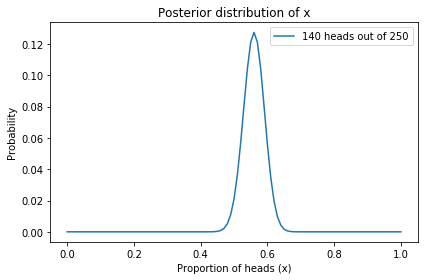

In [79]:
posterior.plot(label='140 heads out of 250')
decorate_euro()
savefig('fig03-02')

The peak of the posterior is at 56%, which is the proportion of heads in the dataset.

In [80]:
pmf.max_prob()

56

Another way to summarize the distribution is the posterior mean.  Given a PMF, we can compute the mean by multiplying each value by its probability and adding up the products:

$\mathrm{mean} = \sum_i p_i q_i$

So we can compute the posterior mean like this:


In [81]:
np.sum(pmf.ps * pmf.qs)

55.952380952380956

Or `Pmf` provides a function that does the same thing.

In [82]:
pmf.mean()

55.952380952380956

## Different priors

Let's see how that looks with different priors.

In [83]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

And another that makes a triangular prior.

In [84]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

Here's what they look like:

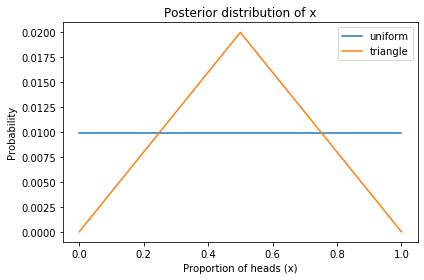

In [85]:
uniform.plot()
triangle.plot()
decorate_euro()

If we update them both with the same data:

In [86]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

The results are almost identical; the remaining difference is unlikely to matter in practice.

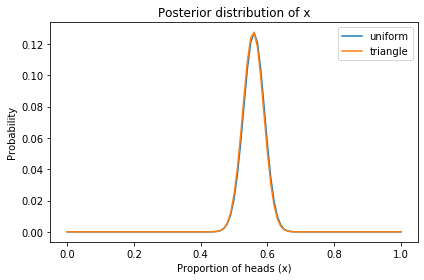

In [87]:
uniform.plot()
triangle.plot()
decorate_euro()

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is `p`, we can compute the probability of `k=140` heads in `n=250` tosses using the binomial PMF.

In [89]:
from scipy.stats import binom

def update_binomial(pmf, data):
    k, n = data
    p = pmf.qs
    likelihood = binom.pmf(k, n, p)
    pmf *= likelihood
    pmf.normalize()

In [90]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

Here's what the posterior looks like.

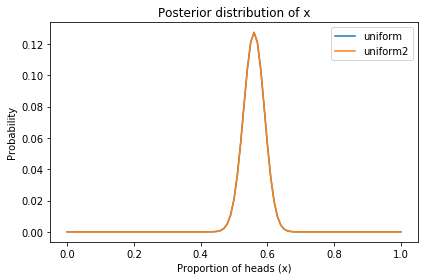

In [91]:
uniform.plot()
uniform2.plot()
decorate_euro()

## Credible interval

We can look up a particular value in the posterior PMF, but the result doesn't mean much, because we could have divided the range (0-100) into as many pieces as we like, and the result would be different.

In [93]:
uniform[0.5]

0.020976526129544665

In [94]:
uniform.le_dist(0.5)

0.04056797774604365

And a 90% credible interval

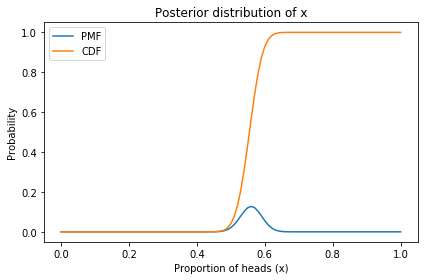

In [95]:
cdf = uniform.make_cdf()
uniform.plot(label='PMF')
cdf.plot(label='CDF')
decorate_euro()

In [96]:
cdf.quantile(0.5)

array(0.56)

In [97]:
uniform.median()

array(0.56)

In [98]:
cdf.quantile([0.25, 0.75])

array([0.54, 0.58])

In [99]:
cdf.quantile([0.05, 0.95])

array([0.51, 0.61])

In [100]:
uniform.credible_interval(0.9)

array([0.51, 0.61])